In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [14]:
%cd /content/drive/My Drive/機械学習/Livedoor-multi
!ls
!git config --global user.email "taishi.ito1026@gmail.com"
!git config --global user.name "Taishi-Ito"

%%bash
echo "# livedoor-multi-classification" >> README.md
!git init
!git add README.md
!git add Livedoorニュースコーパス多値分類.ipynb
!git commit -m "Add Livedoor multi classification in colab"
!git remote add origin git@github.com:Taishi-Ito/livedoor-multi-classification.git
!git branch -M main
!git push -u origin main

# !git add Livedoorニュースコーパス多値分類.ipynb
# !git commit -m "Add Livedoor multi classification in colab"
# !git remote add origin git@github.com:Taishi-Ito/livedoor-multi-classification.git
# !git branch -M main
# !git push -u origin main

SyntaxError: ignored

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [3]:
!pip install protobuf==3.9.2
!pip install transformers==4.20.1 fugashi==1.1.2 ipadic==1.0.0 torchtext==0.11.0 pytorch-lightning==1.6.4 numpy==1.21.6 openpyxl
!pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████▌                   | 834.1 MB 1.2 MB/s eta 0:17:38tcmalloc: large alloc 1147494400 bytes == 0x39d7c000 @  0x7f6253b16615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |███████████████▉                | 1055.7 MB 1.3 MB/s eta 0:13:55tcmalloc: large alloc 1434370048 bytes == 0x7e3d2000 @  0x7f6253b16615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x

In [4]:
import glob  # ファイルの取得に使用
import os # ファイルの取得に使用
import pandas as pd # dataframeを扱う
from sklearn.model_selection import train_test_split # データ分割
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import BertJapaneseTokenizer, BertForSequenceClassification
import pytorch_lightning as pl
import random
import numpy as np
from tqdm import tqdm
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging

# 日本語の事前学習モデル
MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

In [5]:
seed = 1
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [6]:
path = "/content/drive/My Drive/機械学習/text/"  # フォルダの場所を指定

#　ディレクトリ名のみを取得
dir_files = os.listdir(path=path)
dir_names = [f for f in dir_files if os.path.isdir(os.path.join(path, f))]

# ラベル数
label_n = len(dir_names)
print(f'=={label_n}==')

# dataframe作成用にテキストとラベルのリストを作る
text_list = []
label_list = []
label_dic = {}

for i, dir_name in enumerate(dir_names):
    label_dic[i] = dir_name
    file_names = glob.glob(path + dir_name + "/*.txt") 
    for file_name in file_names:
        if os.path.basename(file_name) == "LICENSE.txt":
            continue
        with open(file_name, "r") as f:
            text = f.readlines()[3:]
            text = "".join(text)
            text = text.translate(str.maketrans({"\n":"", "\t":"", "\r":"", "\u3000":""})) 
            text_list.append(text)
            label_list.append(i)

==3==


In [7]:
# dataframeを作成する
document_df = pd.DataFrame(data={'text': text_list,'label': label_list})
print(f'{document_df.head()}')

==                                                text  label
0  東京工業大学とソニーは、世界最高速6.3 Gb/sのミリ波無線データ伝送を実現する高周波 (...      0
1  就職活動や外回りの仕事中もインターネットが使えることで、面接や取引が有利に進んだ、という場面...      0
2  行楽の季節は残念なことに、過酷な交通渋滞の季節でもある。運転者の体力的消耗は、道路を共有する...      0
3  テレビCMも多く放送されているため、誰もが見たことがあるだろうauの人気プランと言えば「au...      0
4  先日、気象庁より「関東甲信地方は梅雨入りしたとみられる」と発表された。平年より1日遅く、統計...      0==


In [8]:
# 比重でラベルの重み計算
label_count = document_df['label'].value_counts(sort=False)
label_count_dict = label_count.to_dict()
print(f'各ラベル数:{label_count_dict}')

label_weight = []
for i in range(label_n):
    rate = (label_count_dict[i] / len(document_df))*100
    weight = 100 - rate
    label_weight.append(weight)
print(f'ラベル重み：{label_weight}')

=={0: 398, 1: 504, 2: 390}==
==[69.19504643962848, 60.9907120743034, 69.81424148606811]==


In [9]:
# 学習&検証データとテストデータを分割
train_val_df, test_df = train_test_split(document_df, test_size=0.2, random_state=42)
# 学習データと検証データに分割
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

# インデックスをリセット
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [10]:
class DatasetGenerator(Dataset):
    def __init__(self, data, tokenizer, label_weight):
        self.data = data
        self.tokenizer = tokenizer
        self.class_weights = label_weight
        self.sample_weights = [0] * len(data)
        self.max_length = 256

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_row = self.data.iloc[index]
        text = data_row['text']
        labels = data_row['label']
        
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return dict(
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            token_type_ids=encoding["token_type_ids"].flatten(),
            labels=torch.tensor(labels)
        )
    
    def get_sampler(self):
        for idx, row in self.data.iterrows():
            label = row['label']
            class_weight = self.class_weights[label]
            self.sample_weights[idx] = class_weight
        sampler = WeightedRandomSampler(self.sample_weights, num_samples=len(self.sample_weights), replacement=True)
        return sampler

In [11]:
class DataModuleGenerator(pl.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, tokenizer, batch_size, label_weight):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.label_weight = label_weight
        
    def setup(self):
        self.train_dataset = DatasetGenerator(self.train_df, self.tokenizer, self.label_weight)
        self.valid_dataset = DatasetGenerator(self.val_df, self.tokenizer, self.label_weight)
        self.test_dataset = DatasetGenerator(self.test_df, self.tokenizer, self.label_weight)
        self.train_sampler = self.train_dataset.get_sampler()
        self.valid_sampler = self.valid_dataset.get_sampler()

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size["train"], num_workers=os.cpu_count(), sampler=self.train_sampler)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.batch_size["val"], num_workers=os.cpu_count(), sampler=self.valid_sampler)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size["test"], num_workers=os.cpu_count())


In [12]:
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
data_module = DataModuleGenerator(train_df, val_df, test_df, tokenizer, {"train": 8, "val": 8, "test": 8}, label_weight)
data_module.setup()

Downloading:   0%|          | 0.00/252k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

In [13]:
from torch import nn
from IPython.core.debugger import Pdb;

# Pytorch Lightningを使用するためのClass
class Model(pl.LightningModule):
        
    def __init__(self, model_name, num_labels, lr):
        super().__init__()
        self.save_hyperparameters() 
        self.bert_sc = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        )

        
    def training_step(self, batch, batch_idx):
        output = self.bert_sc(**batch)
        output_labels = torch.argmax(nn.functional.softmax(output.logits, dim=-1), dim=1)
        output_softmax = nn.functional.softmax(output.logits, dim=-1)
        weights = torch.tensor(label_weight).cuda()
        cross_entropy_loss = nn.CrossEntropyLoss(weight=weights)
        loss = cross_entropy_loss(output.logits, batch['labels'])
        # loss = output.loss
        self.log('train_loss', loss) # 損失を'train_loss'の名前でログをとる。
        return loss
        
    def validation_step(self, batch, batch_idx):
        output = self.bert_sc(**batch)
        val_loss = output.loss
        self.log('val_loss', val_loss) # 損失を'val_loss'の名前でログをとる。

    def test_step(self, batch, batch_idx):
        labels = batch.pop('labels') # バッチからラベルを取得
        output = self.bert_sc(**batch)
        labels_predicted = output.logits.argmax(-1)
        num_correct = ( labels_predicted == labels ).sum().item()
        accuracy = num_correct/labels.size(0) #精度
        self.log('accuracy', accuracy) # 精度を'accuracy'の名前でログをとる。

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [14]:
# 学習時にモデルの重みを保存する条件を指定
checkpoint = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_weights_only=True,
    dirpath='models',
) 

early_stopping = EarlyStopping('val_loss',verbose=True,)


# 学習の方法を指定
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=20,
    callbacks = [checkpoint, early_stopping]
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [15]:
# PyTorch Lightningモデルのロード
model = Model(MODEL_NAME, num_labels=label_n, lr=1e-5)

# ファインチューニングを行う。
trainer.fit(model, data_module.train_dataloader(),  data_module.val_dataloader()) 

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.428


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.242 >= min_delta = 0.0. New best score: 0.186


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 0.110


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.110. Signaling Trainer to stop.


==/content/models/epoch=4-step=585.ckpt==


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

==tensor([[ 2.5115,  0.2258, -2.4989],
        [-1.3610,  3.6593, -2.8701],
        [-1.9783,  4.1061, -2.6215],
        [ 1.2393,  0.9478, -2.3478],
        [ 3.4687, -1.1407, -2.4458],
        [-2.2881, -2.3962,  4.6477],
        [ 3.5818, -1.1485, -2.7131],
        [-0.0563,  3.0956, -3.2723],
        [ 1.5338,  1.2898, -3.1215],
        [ 3.6520, -1.3602, -2.0121],
        [-2.2202, -2.1314,  4.3696],
        [ 2.8075, -2.2480, -0.7202],
        [-0.9234,  3.8526, -3.0635],
        [-2.4101, -1.8408,  4.3066],
        [-2.2971, -2.3853,  4.7535],
        [ 0.4385,  2.0708, -3.0665],
        [-1.8081, -1.2553,  3.1439],
        [-2.3342, -2.0224,  4.1892],
        [ 3.9729, -1.9537, -2.1255],
        [-1.6799,  4.0935, -2.7820],
        [-2.3039, -2.3909,  4.7568],
        [-2.1611, -2.4366,  4.3596],
        [ 3.5321, -1.1337, -2.4108],
        [-2.2079, -2.4733,  4.6805],
        [ 3.6097, -2.4091, -1.6304],
        [ 4.1767, -1.7254, -2.3545],
        [ 3.0878, -1.2038, -1.8579],

,model_str,model,accuracy_score,precision_score,recall_score,f1_score
0,"BERT: tokenizer_max_length=320, WeightedRandomSampler(class_weights=[1, 50]), CrossEntropyLoss(weight=[1, 500])",BERT,0.918919,0.918433,0.922308,0.9197


              precision    recall  f1-score   support

           0       0.91      0.87      0.89        86
           1       0.93      0.91      0.92        98
           2       0.91      0.99      0.95        75

    accuracy                           0.92       259
   macro avg       0.92      0.92      0.92       259
weighted avg       0.92      0.92      0.92       259



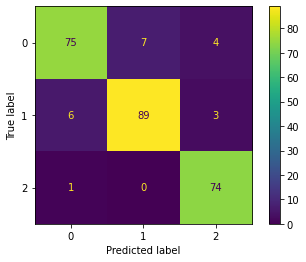

In [16]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
pd.set_option("display.max_colwidth", 10000)


# モデルのロード
best_model_path = checkpoint.best_model_path
model = Model.load_from_checkpoint(best_model_path)
bert_sc = model.bert_sc.cuda()
# データの符号化
encoding = tokenizer(
    test_df['text'].tolist(), 
    return_tensors='pt',
    max_length=256, 
    padding='max_length',
    truncation=True
)
encoding = { k: v.cuda() for k, v in encoding.items() }


# BERTへデータを入力し分類スコアを得る。
with torch.no_grad():
    output = bert_sc(**encoding)
preds = output.logits.argmax(-1)
# 結果を表示
targets = test_df['label'].tolist()
preds_np = preds.to('cpu').detach().numpy().copy()
# AUC
# normal_svc_auc = auc(recall,precision)
# accuracy_score
# pred_y = normal_svc.predict(test_x_vector)
bert_a_score = accuracy_score(targets, preds_np)
# precision_score
bert_p_score = precision_score(targets, preds_np, average='macro')
# recall_score
bert_r_score = recall_score(targets, preds_np, average='macro')
# f1_score
bert_f_score = f1_score(targets, preds_np, average='macro')
# confusion_matrix
bert_confusion_matrix = confusion_matrix(targets, preds_np)
# 表示用データフレーム
df_model = pd.DataFrame(columns={'model_str', 'model', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score'})
df_model = df_model.append({
      'model_str': 'BERT: tokenizer_max_length=320, WeightedRandomSampler(class_weights=[1, 50]), CrossEntropyLoss(weight=[1, 500])', 'model' : 'BERT' , 'accuracy_score' : bert_a_score,
      'precision_score' : bert_p_score, 'recall_score' : bert_r_score, 'f1_score' : bert_f_score
    } , ignore_index=True)
df_model = df_model.reindex(columns=['model_str', 'model', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score'])
display(df_model)
# print(f'accuracy: {bert_a_score}, precision: {bert_p_score}, recall: {bert_r_score}, f: {bert_f_score}, confusion_matrix: {bert_confusion_matrix}')
# classification_report
bert_classification_report = classification_report(targets, preds_np)
print(bert_classification_report)
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
cm = confusion_matrix(targets, preds_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()